In [1]:
from sigmf_pytorch_dataset import SigMFDataset
from torchsig.utils.visualize import IQVisualizer, SpectrogramVisualizer, two_channel_to_complex
from torchsig.utils.dataset import SignalDataset
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from typing import List
from tqdm import tqdm
import numpy as np

In [2]:
dataset_path = "./dev_data/torchsig_test/"

In [3]:
dataset = SigMFDataset( root=dataset_path, allowed_filetypes=[".sigmf-data"])
dataset_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in dataset:
    dataset_class_counts[dataset.class_list[label]] += 1
print(f"{len(dataset)=}")
print(dataset_class_counts)

['samples', 'fhss_css', '.']
Adding mini2_telem to class list
Adding mini2_video to class list
Adding fhss_css to class list
Class List: ['mini2_telem', 'mini2_video', 'fhss_css']
len(dataset)=1409
{'mini2_telem': 337, 'mini2_video': 776, 'fhss_css': 296}


In [4]:
# zst_dataset = SigMFDataset(root=dataset_path, allowed_filetypes=[".zst"])
# print(f"{len(zst_dataset)=}")
# dataset_class_counts = {class_name:0 for class_name in zst_dataset.class_list}
# for data,label in zst_dataset:
#     dataset_class_counts[zst_dataset.class_list[label]] += 1
# print(dataset_class_counts)

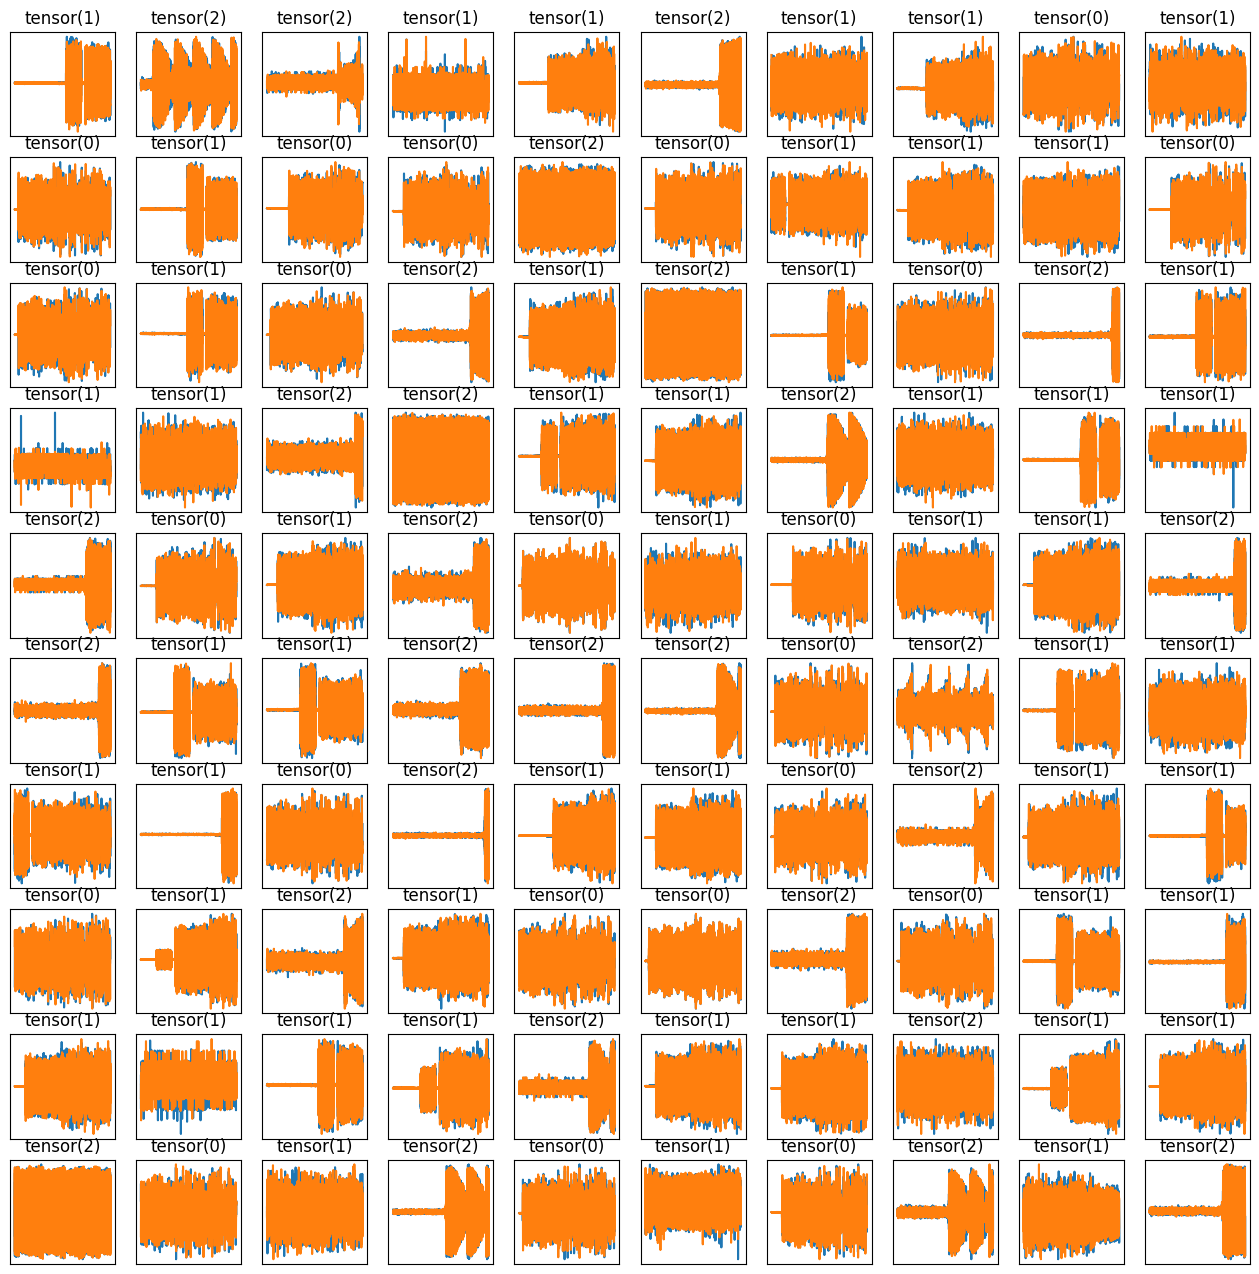

In [6]:
data_loader = DataLoader(
    dataset=dataset,
    batch_size=100,
    shuffle=True,
)

visualizer = IQVisualizer(
    data_loader=data_loader
)

for figure in iter(visualizer):
    figure.set_size_inches(16, 16)
    plt.show()
    break

# SigMF based Model Training

In [7]:
from torchsig.models.iq_models.efficientnet.efficientnet import efficientnet_b4
from pytorch_lightning.callbacks import ModelCheckpoint
from torchsig.utils.cm_plotter import plot_confusion_matrix
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import classification_report
from torchsig.datasets.sig53 import Sig53
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import torchsig.transforms as ST
import numpy as np
import torchsig
import torch
import os
from sigmf_db_dataset import SigMFDB
from sigmf_pytorch_dataset import SigMFDataset


### Load the SigMF File dataset
and generate the class list

In [8]:
transform = ST.Compose([
    # ST.RandomPhaseShift(phase_offset=(-1, 1)),
    ST.Normalize(norm=np.inf),
    ST.ComplexTo2D(),
])
# class_list = ['mini2_video']

dataset = SigMFDataset( root=dataset_path,
                       transform=transform,
                       # class_list=class_list,
)
# labels = []
# for _, label in dataset:
#     labels.append(label)
# #class_list=np.unique(labels).tolist()
# print("Unique labels: {}".format(np.unique(labels)))

['samples', 'fhss_css', '.']
Adding mini2_telem to class list
Adding mini2_video to class list
Adding fhss_css to class list
Class List: ['mini2_telem', 'mini2_video', 'fhss_css']


### SigMF DB Data Loaders
The number of workers needs to be set to 0 when there is not a GPU. Otherwise the dataloader tries to pickle the environment variables: https://github.com/acids-ircam/RAVE/issues/10#issuecomment-1002708207

In [9]:

# # Specify Sig53 Options

# root = "sigmf/"
# train = False
# impaired = False
# class_list = ['signal', 'mini2_video']
# print("Class List: {}".format(class_list))
# transform = ST.Compose([
#     ST.RandomPhaseShift(phase_offset=(-1, 1)),
#     ST.Normalize(norm=np.inf),
#     ST.ComplexTo2D(),
# ])
# target_transform = ST.DescToClassIndex(class_list=class_list)

# sig53_clean_train = SigMFDB(
#     root=root, 
#     transform=transform,
#     target_transform=target_transform,
#     use_signal_data=True,
# )

# # Retrieve a sample and print out information to verify
# print(len(sig53_clean_train))
# idx = np.random.randint(len(sig53_clean_train))
# data, label = sig53_clean_train[idx]
# print("Dataset length: {}".format(len(sig53_clean_train)))
# print("Data shape: {}".format(data.shape))
# print("Data Object: {}".format(data))
# print("Label Index: {}".format(label))


# train_dataloader = DataLoader(
#     sig53_clean_train ,
#     batch_size=16,
#     num_workers=0,
#     shuffle=True,
#     drop_last=True,
# )
# val_dataloader = DataLoader(
#     sig53_clean_train ,
#     batch_size=16,
#     num_workers=0,
#     shuffle=False,
#     drop_last=True,
# )

### SigMF File Dataloaders
This is working

In [10]:
train_data, val_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in train_data:
    train_class_counts[dataset.class_list[label]] += 1
print(f"{train_class_counts=}")

val_class_counts = {class_name:0 for class_name in dataset.class_list}
for data,label in val_data:
    val_class_counts[dataset.class_list[label]] += 1
print(f"{val_class_counts=}")

weight = 1. / np.array(list(train_class_counts.values()))
samples_weight = np.array([weight[t] for d,t in train_data])

samples_weight = torch.from_numpy(samples_weight)
sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))

train_dataloader = DataLoader(
    dataset=train_data, #sig53_clean_train ,
    batch_size=16,
    num_workers=8,
    sampler=sampler,
    # shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    dataset=val_data, #sig53_clean_train ,
    batch_size=16,
    num_workers=8,
    shuffle=False,
    drop_last=True,
)

train_class_counts={'mini2_telem': 263, 'mini2_video': 625, 'fhss_css': 240}
val_class_counts={'mini2_telem': 74, 'mini2_video': 151, 'fhss_css': 56}


In [11]:
model = efficientnet_b4(
    pretrained=True,
    path="efficientnet_b4.pt",
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
class ExampleNetwork(LightningModule):
    def __init__(self, model, data_loader, val_data_loader):
        super(ExampleNetwork, self).__init__()
        self.mdl = model
        self.data_loader = data_loader
        self.val_data_loader = val_data_loader

        # Hyperparameters
        self.lr = 0.001
        self.batch_size = data_loader.batch_size

    def forward(self, x):
        return self.mdl(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)

    def train_dataloader(self):
        return self.data_loader

    def training_step(self, batch, batch_nb):
        x, y = batch
        # print(x.shape)
        # print(y.shape)
        y = torch.squeeze(y.to(torch.int64))
        loss = F.cross_entropy(self(x.float()), y)
        return {"loss": loss}

    def val_dataloader(self):
        return self.val_data_loader

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y = torch.squeeze(y.to(torch.int64))
        val_loss = F.cross_entropy(self(x.float()), y)
        self.log("val_loss", val_loss, prog_bar=True)
        return {"val_loss": val_loss}

example_model = ExampleNetwork(model, train_dataloader, val_dataloader)

In [13]:
# Setup checkpoint callbacks
checkpoint_filename = "{}/checkpoints/checkpoint".format(os.getcwd())
checkpoint_callback = ModelCheckpoint(
    filename=checkpoint_filename,
    save_top_k=True,
    monitor="val_loss",
    mode="min",
)
print("Doing stuff")
# Create and fit trainer
epochs = 20
trainer = Trainer(
    max_epochs=epochs, callbacks=checkpoint_callback, accelerator="gpu", devices=1
)
trainer.fit(example_model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Doing stuff


/home/ltindall/.pyenv/versions/3.10.9/envs/rfml-dev/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type         | Params
--------------------------------------
0 | mdl  | EfficientNet | 17.3 M
--------------------------------------
17.3 M    Trainable params
0         Non-trainable params
17.3 M    Total params
69.085    Total estimated model params size (MB)


Sanity Checking: |                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                       | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
checkpoint_callback.best_model_path

'/home/ltindall/rfml-dev/rfml-dev/checkpoints/checkpoint-v3.ckpt'

## Evaluate the Trained Model

In [15]:
# Load best checkpoint
checkpoint = torch.load(checkpoint_callback.best_model_path, map_location=lambda storage, loc: storage)
example_model.load_state_dict(checkpoint["state_dict"], strict=False)
example_model = example_model.eval()
example_model = example_model.cuda() if torch.cuda.is_available() else example_model

In [16]:
# Infer results over validation set
num_test_examples = len(val_data)
# num_classes = 5 #len(list(Sig53._idx_to_name_dict.values()))
# y_raw_preds = np.empty((num_test_examples,num_classes))
y_preds = np.zeros((num_test_examples,))
y_true = np.zeros((num_test_examples,))

for i in tqdm(range(0,num_test_examples)):
    # Retrieve data
    idx = i # Use index if evaluating over full dataset
    data, label = val_data[idx]
    # Infer
    data = torch.from_numpy(np.expand_dims(data,0)).float()
    data = data.cuda() if torch.cuda.is_available() else data
    pred_tmp = example_model.predict(data)
    pred_tmp = pred_tmp.cpu().numpy() if torch.cuda.is_available() else pred_tmp
    # Argmax
    y_preds[i] = np.argmax(pred_tmp)
    # Store label
    y_true[i] = label

100%|███████████████████████████████████████████████████| 281/281 [00:06<00:00, 41.93it/s]


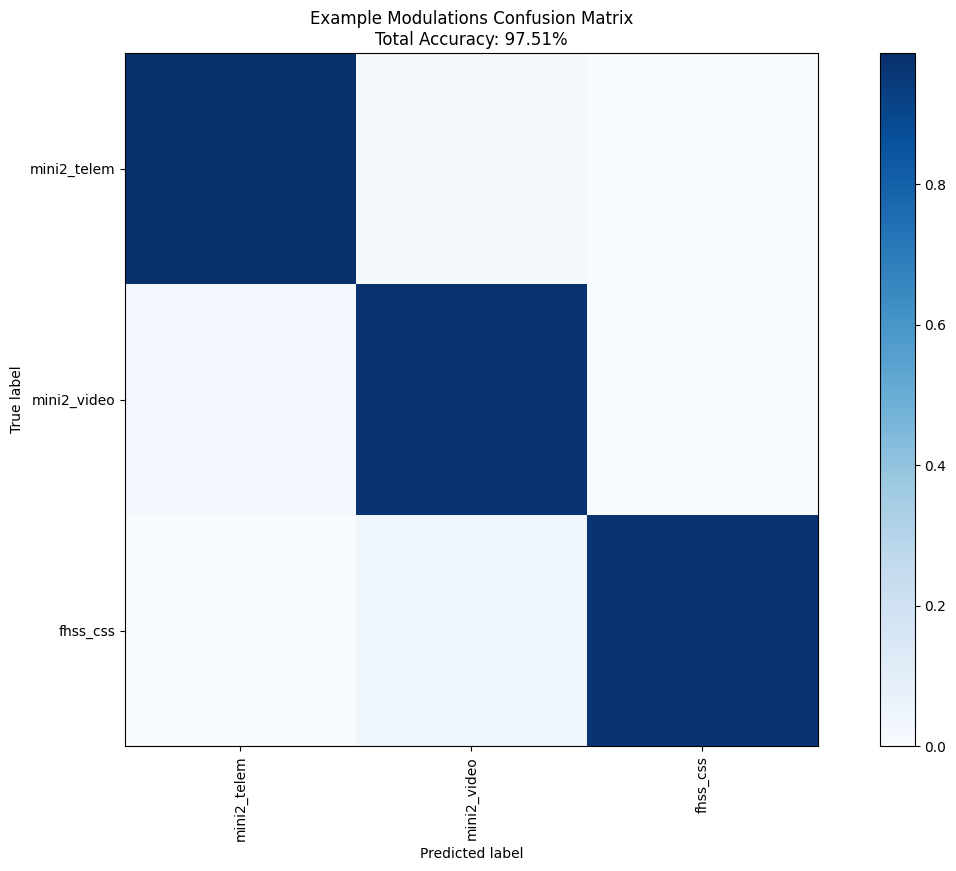

In [17]:
acc = np.sum(np.asarray(y_preds)==np.asarray(y_true))/len(y_true)
plot_confusion_matrix(
    y_true, 
    y_preds, 
    classes=dataset.class_list,
    normalize=True,
    title="Example Modulations Confusion Matrix\nTotal Accuracy: {:.2f}%".format(acc*100),
    text=False,
    rotate_x_text=90,
    figsize=(16,9),
)
plt.show()

In [18]:
num_test_examples

281